## Importing Libraries

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import tensorflow as tf

## Fetching the BTC Data
Data used in this is of each day for the past 4 years

In [6]:
data = yf.Ticker('BTC-USD').history('4y','1d')
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1462 entries, 2018-06-16 to 2022-06-16
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1462 non-null   float64
 1   High          1462 non-null   float64
 2   Low           1462 non-null   float64
 3   Close         1462 non-null   float64
 4   Volume        1462 non-null   int64  
 5   Dividends     1462 non-null   int64  
 6   Stock Splits  1462 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 91.4 KB


In [8]:
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2018-06-16,6455.450195,6592.490234,6402.290039,6550.160156,3194170112,0,0
2018-06-17,6545.529785,6589.109863,6499.270020,6499.270020,3104019968,0,0
2018-06-18,6510.069824,6781.140137,6446.680176,6734.819824,4039200000,0,0
2018-06-19,6742.390137,6822.500000,6709.919922,6769.939941,4057029888,0,0
2018-06-20,6770.759766,6821.560059,6611.879883,6776.549805,3888640000,0,0


## Removing Unnecessary columns 

In [20]:
data.reset_index(inplace=True)
data.rename(columns={'index':'Date'},inplace=True)
data.drop(columns=['Dividends','Stock Splits','Date'],inplace=True)
data.head()

,Open,High,Low,Close,Volume
0,6455.450195,6592.490234,6402.290039,6550.160156,3194170112
1,6545.529785,6589.109863,6499.270020,6499.270020,3104019968
2,6510.069824,6781.140137,6446.680176,6734.819824,4039200000
3,6742.390137,6822.500000,6709.919922,6769.939941,4057029888
4,6770.759766,6821.560059,6611.879883,6776.549805,3888640000


## Splitting the data into test and train

In [21]:
train = data.iloc[:1012]
test = data.iloc[1012:]
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 450 entries, 1012 to 1461
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    450 non-null    float64
 1   High    450 non-null    float64
 2   Low     450 non-null    float64
 3   Close   450 non-null    float64
 4   Volume  450 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 17.7 KB


### Preprocessing the data

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.fit_transform(test)
scaled_test.shape,scaled_train.shape

((450, 5), (1012, 5))

## Generating a Time Series for the data
We split the data into X,y such that Last 45 days of data predict the next day of data

In [37]:
from keras.preprocessing.sequence import TimeseriesGenerator
# define generator
n_input = 45
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=45, batch_size=1)

In [29]:
X,y = generator[0]
print(f'Given the Array: \n{X.shape}')
print(f'Predict this y: \n {y.shape}')

Given the Array: 
(1, 45, 5)
Predict this y: 
 (1, 5)


## Building the Seq2Seq Model

In [31]:
n_hidden = 200
input_train = tf.keras.layers.Input(shape=(45, 5))
output_train = tf.keras.layers.Input(shape=(1, 5))
encoder_stack_h, encoder_last_h, encoder_last_c = tf.keras.layers.LSTM(
    n_hidden, activation='tanh', dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)

decoder_input = tf.keras.layers.RepeatVector(output_train.shape[1])(encoder_last_h)
decoder_stack_h = tf.keras.layers.LSTM(n_hidden, activation='tanh', dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_input, initial_state=[encoder_last_h, encoder_last_c])

attention = tf.keras.layers.dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = tf.keras.layers.Activation('softmax')(attention)

context = tf.keras.layers.dot([attention, encoder_stack_h], axes=[2,1])

decoder_combined_context = tf.keras.layers.concatenate([context, decoder_stack_h])
out = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(output_train.shape[2]))(decoder_combined_context)
model = tf.keras.models.Model(inputs=input_train, outputs=out)
model.compile(loss='mean_squared_error', optimizer=tf.keras.optimizers.Adam(), metrics=['mae'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 45, 5)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 45, 200),    164800      ['input_1[0][0]']                
                                 (None, 200),                                                     
                                 (None, 200)]                                                     
                                                                                                  
 repeat_vector (RepeatVector)   (None, 1, 200)       0           ['lstm[0][1]']                   
                                                                                              

### Using a early stopper for the model

In [35]:
earlyStopper=tf.keras.callbacks.EarlyStopping(monitor='mae', patience=10, verbose=1, mode='auto',restore_best_weights=True)

### Training the Model

In [36]:
model.fit(generator,epochs=100,verbose=2,callbacks=earlyStopper)

Epoch 1/100
967/967 - 36s - loss: 0.0027 - mae: 0.0287 - 36s/epoch - 38ms/step
Epoch 2/100
967/967 - 15s - loss: 0.0018 - mae: 0.0246 - 15s/epoch - 16ms/step
Epoch 3/100
967/967 - 12s - loss: 0.0018 - mae: 0.0246 - 12s/epoch - 13ms/step
Epoch 4/100
967/967 - 14s - loss: 0.0012 - mae: 0.0195 - 14s/epoch - 14ms/step
Epoch 5/100
967/967 - 13s - loss: 0.0012 - mae: 0.0196 - 13s/epoch - 13ms/step
Epoch 6/100
967/967 - 12s - loss: 0.0015 - mae: 0.0207 - 12s/epoch - 12ms/step
Epoch 7/100
967/967 - 12s - loss: 9.7866e-04 - mae: 0.0175 - 12s/epoch - 13ms/step
Epoch 8/100
967/967 - 14s - loss: 0.0011 - mae: 0.0183 - 14s/epoch - 15ms/step
Epoch 9/100
967/967 - 15s - loss: 8.9002e-04 - mae: 0.0168 - 15s/epoch - 15ms/step
Epoch 10/100
967/967 - 15s - loss: 0.0011 - mae: 0.0186 - 15s/epoch - 15ms/step
Epoch 11/100
967/967 - 15s - loss: 0.0010 - mae: 0.0181 - 15s/epoch - 16ms/step
Epoch 12/100
967/967 - 12s - loss: 9.5881e-04 - mae: 0.0175 - 12s/epoch - 13ms/step
Epoch 13/100
967/967 - 15s - loss: 8.

## Getting Predictions and Plotting them

In [38]:
pred=list()
true_values=list()
for i in range(len(test_generator)):
    X_test,y_test = test_generator[i]
    pred.append(model.predict(X_test))
    true_values.append(y_test)
pred[:5]

[array([[[0.8006621 , 0.8159026 , 0.82025313, 0.8082081 , 0.1467342 ]]],
       dtype=float32),
 array([[[0.8059878 , 0.8210389 , 0.8250892 , 0.8131957 , 0.14660498]]],
       dtype=float32),
 array([[[0.8097021 , 0.82489675, 0.82862365, 0.8166548 , 0.1465649 ]]],
       dtype=float32),
 array([[[0.80836755, 0.82406706, 0.82761693, 0.81535417, 0.14697897]]],
       dtype=float32),
 array([[[0.8073904 , 0.8228725 , 0.82729256, 0.81461763, 0.14613251]]],
       dtype=float32)]

In [39]:
pred = scaler.inverse_transform(np.array(pred).reshape(405,5))
true_values = scaler.inverse_transform(np.array(true_values).reshape(405,5))
true_values[0]

array([5.73527656e+04, 5.94646133e+04, 5.69752109e+04, 5.88037773e+04,
       6.53829806e+10])

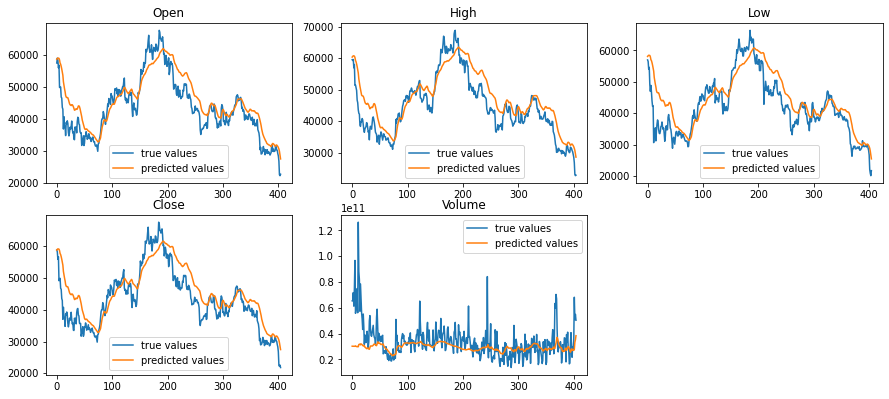

In [40]:
plt.figure(figsize=(15,10))
for i in range(5):
    predicted_values = list()
    original_values = list()
    plt.subplot(3,3,i+1)
    for j in range(len(test_generator)):
        predicted_values.append(pred[j][i])
    for k in range(len(test_generator)):
        original_values.append(true_values[k][i])
    plt.plot(original_values,label='true values')
    plt.plot(predicted_values,label='predicted values')
    plt.title(data.columns[i])
    plt.legend()